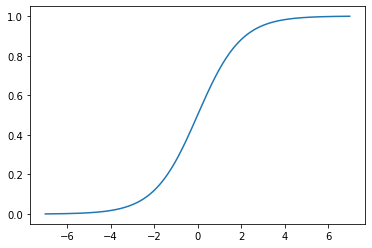

In [48]:
from matplotlib import pyplot as plt
import numpy as np
from math import exp
from PIL import Image
import sklearn


t = np.arange(-7, 7, 0.01)

# red dashes, blue squares and green triangles
plt.plot(t, 1/(1+(np.exp(-t))))
plt.savefig('logistic.png')



Hi! This is a python notebook demoing using Logistic Regression for sentiment analysis on the public IMDB movie reviews dataset.

Idea creds:
https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184

Dataset is available at:
https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset

  * What is logistic regression and what is it used for?  
      * Go-to for binary classification
         * Binary classification is useful when we have 2 choices(b/w, y/n, good/bad)
         * Not so useful when we don't have discrete choices ie. pretty good
      * Like many machine learning techniques it was stolen from statistics
          * At its core it uses the logistic function aka the sigmoid function
          * Logistic function takes any real-valued number and maps it between 0 and 1  
          # $\frac{1}{1+e^{-x}} \quad \forall x \in \mathbb{R}$
       * We won't go into exactly how it works, but it essentially creates a plane that separates high dimensional data using maximum likelihood estimation(sklearn uses a numerical optimization algorithm.)


  * Disadvantages and Advantages
      * Disadvantages:
          * Because it relies on features vectors it can struggle with noise
              * Can solve this by cleaning our data
          * Overfitting
              * Get more data
              * Regularization
          * Bias
              * Classic case is a rare disease
              * Upsample or Downsample data
          * Non-Convergence
              * Clean data--check for highly correlated pts
      * Advantages:
          * Computationally efficient
          * Easy to use
          * Well documented and understood

In [1]:
#sckit_learn is a very well documented machine learning library. It's a little older than tf, but still very relevant.
import sklearn
print(sklearn.__version__)

0.21.2


In [2]:
reviews_train = []
for line in open('full_train.txt', 'r'):
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('full_test.txt', 'r'):
    reviews_test.append(line.strip())

In [3]:
print(reviews_train[0])

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [4]:
import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

In [5]:
print(reviews_train_clean[0])

bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my 35 years in the teaching profession lead me to believe that bromwell highs satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled  at  high a classic line inspector im here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isnt


In [6]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)



In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

target = [1 if i < 12500 else 0 for i in range(25000)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

Accuracy for C=0.01: 0.87456
Accuracy for C=0.05: 0.88096
Accuracy for C=0.25: 0.87824
Accuracy for C=0.5: 0.8744
Accuracy for C=1: 0.87344


In [10]:
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))

Final Accuracy: 0.88152


In [11]:
feature_to_coef = {word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0])}
print('best positives:')
for best_positive in sorted(feature_to_coef.items(), 
    key=lambda x: x[1], reverse=True)[:5]:
    print (best_positive)
    
print('\n best negatives:')   
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

best positives:
('excellent', 0.9292549055817553)
('perfect', 0.7907005762467144)
('great', 0.6745323564933414)
('amazing', 0.6127039869748403)
('superb', 0.6019367969264237)

 best negatives:
('worst', -1.3645958793195605)
('waste', -1.1664241934163166)
('awful', -1.0324189239200765)
('poorly', -0.8752018714482658)
('boring', -0.8563543372884128)


In [12]:
noise=set(['if', 'for', 'and', 'in', 'of', 'at', 'the', 'is', 'i', 'a', 'it'])
def remove_noise_words(corpus):
    removed_noise_words = []
    for review in corpus:
        removed_noise_words.append(
            ' '.join([word for word in review.split() 
                      if word not in noise]))
    return removed_noise_words

no_noise_words_train = remove_noise_words(reviews_train_clean)
no_noise_words_test = remove_noise_words(reviews_test_clean)

In [13]:
print(no_noise_words_train[0])

bromwell high cartoon comedy ran same time as some other programs about school life such as teachers my 35 years teaching profession lead me to believe that bromwell highs satire much closer to reality than teachers scramble to survive financially insightful students who can see right through their pathetic teachers pomp pettiness whole situation all remind me schools knew their students when saw episode which student repeatedly tried to burn down school immediately recalled high classic line inspector im here to sack one your teachers student welcome to bromwell high expect that many adults my age think that bromwell high far fetched what pity that isnt


In [14]:
cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)


In [61]:
target = [1 if i < 12500 else 0 for i in range(25000)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

/Users/skandera/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.87152
Accuracy for C=0.05: 0.8816
Accuracy for C=0.25: 0.88128
Accuracy for C=0.5: 0.87808
Accuracy for C=1: 0.87488


In [62]:
cv = CountVectorizer(binary=True, ngram_range=(1, 2))
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)


target = [1 if i < 12500 else 0 for i in range(25000)]

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))

/Users/skandera/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.88272
Accuracy for C=0.05: 0.888
Accuracy for C=0.25: 0.88816
Accuracy for C=0.5: 0.88832
Accuracy for C=1: 0.88832
